Python code for various finite difference methods and heston model for pricing options

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as si
import math

amzn = yf.Ticker("AMZN")
opt_maturity_dates_amzn=amzn.options
d_amzn={}
for i,x in enumerate(opt_maturity_dates_amzn):
     d_amzn["Maturity{}".format(i)]=amzn.option_chain(x)
     
##### QUES 1  PART 1  
def European_EFD(s, k, T, sig, r, div, cp, nj, n=100):
    """
    s: stock Price
    k: strike price
    t: expiration time
    div: dividend
    sig: volatility
    r: risk-free rate
    cp: +1/-1 for call/put
    n: binomial Steps
    """
    # initial calculations
    dt = T / n
    v = r - div - 0.5 * (sig ** 2)
    dx= sig*(math.sqrt(3*dt)) 
    edx = math.exp(dx)

    pu = 0.5 * dt * ((sig / dx) ** 2 + v / dx)
    pm = 1.0 - dt * (sig / dx) ** 2 - r * dt
    pd = 0.5 * dt * ((sig / dx) ** 2 - v / dx)
   

    disc = math.exp(-r * dt)
    St = np.zeros(2 * nj + 1)
    C = np.zeros(shape=(n + 1, 2 * nj + 1))
    # initialise the asset prices at maturity N

    St[0] = s * math.exp(-n * dx)

    for j in range(1, 2 * nj + 1, 1):
        St[j] = St[j - 1] * edx
   

    # initialise option values at maturity

    for i in range(-nj, nj + 1, 1):
        if cp==1:
            C[n, i] = max(0.0, St[i] - k)
        else:
            C[n, i] = max(0.0, k - St[i])


    # step back through tree

    for i in range(n - 1, -1, -1):
        for j in range(1, 2 * nj, 1):
            C[i, j] = pu * C[i + 1, j + 1] + pm * C[i + 1, j] + pd * C[i + 1, j - 1]
        C[i, 0] = C[i, 1]
        C[i, 2 * nj] = C[i, 2 * nj - 1] + (St[2 * nj] - St[2 * nj - 1])
    

    European_option = C[0, nj]

    return European_option





#### QUESTION 1 PART 2

def solve_implicit_tridiagonal_system(C, pu, pm, pd, lambda_L, lambda_U,i,nj):
    pmp =np.zeros(2 * nj + 1)
    pp =np.zeros(2 * nj + 1)
    pmp[1] = pm + pd
    pp[1] = C[i+1,1] + pd*lambda_L

    for j in range(2,2*nj):
        pmp[j] = pm - pu*pd/pmp[j-1]
        pp[j]  = C[i+1,j] - pp[j-1]*pd/pmp[j-1]

    # boundary condition

    C[i,2*nj] = (pp[2*nj-1]+pmp[2*nj-1]*lambda_U)/(pu+pmp[2*nj-1])

    C[i,2*nj-1] = C[i,2*nj] - lambda_U

    # back substitution

    for j in range(2*nj-2,0,-1):
        C[i,j] = (pp[j] - pu*C[i,j+1])/pmp[j]

    C[i,0] = C[i,1] - lambda_L
    return C

def European_IFD(s, k, T, sig, r, div, cp, nj, n=100):
    """
    s: stock Price
    k: strike price
    t: expiration time
    div: dividend
    sig: volatility
    r: risk-free rate
    cp: +1/-1 for call/put
    am : True/False for American/European
    n: binomial Steps
    """
    # initial calculations
    dt = T / n
    dx= sig*(math.sqrt(3*dt))
    v = r - div - 0.5 * (sig ** 2)
    edx = math.exp(dx)

    pu = -0.5 * dt * ((sig / dx) ** 2 + v / dx)
    pm = 1.0 + dt * (sig / dx) ** 2 + r * dt
    pd = -0.5 * dt * ((sig / dx) ** 2 - v / dx)
   
    disc = math.exp(-r * dt)
    St = np.zeros(2 * nj + 1)
    C = np.zeros(shape=(n + 1, 2 * nj + 1))
    # initialise the asset prices at maturity N

    St[0] = s * math.exp(-n * dx)

    for j in range(1, 2 * nj + 1, 1):
        St[j] = St[j - 1] * edx

    # initialise option values at maturity

    for i in range(-nj, nj + 1, 1):
        if cp==1:
            C[n, i] = max(0.0, St[i] - k)
        else:
            C[n, i] = max(0.0, k - St[i])

    # compute derivative boundary

    if cp==1:
        lambda_L = 0
        lambda_U = St[2*nj] - St[2*nj-1]
    else:
        lambda_L = -1*(St[1] - St[0])
        lambda_U = 0.0


    # step back through tree

    for i in range(n - 1, -1, -1):
        C = solve_implicit_tridiagonal_system(C,pu,pm,pd,lambda_L,lambda_U,i,nj)

    European_option = C[0, nj]

    return European_option

### QUESTION 1 PART 3
    
def solve_CN_tridiagonal_system(C, pu, pm, pd, lambda_L, lambda_U,i,nj):
    pmp =np.zeros(2 * nj + 1)
    pp =np.zeros(2 * nj + 1)
    pmp[1] = pm + pd
    pp[1] = -pu*C[i+1,2]-(pm-2)*C[i+1,1] -pd*C[i+1,0] + pd*lambda_L

    for j in range(2,2*nj):
        pmp[j] = pm - pu*pd/pmp[j-1]
        pp[j]  = -pu*C[i+1,j+1]-(pm-2)*C[i+1,j] -pd*C[i+1,j-1] - pp[j-1]*pd/pmp[j-1]

    # boundary condition

    C[i,2*nj] = (pp[2*nj-1]+pmp[2*nj-1]*lambda_U)/(pu+pmp[2*nj-1])

    C[i,2*nj-1] = C[i,2*nj] - lambda_U

    # back substitution

    for j in range(2*nj-2,0,-1):
        C[i,j] = (pp[j] - pu*C[i,j+1])/pmp[j]

    C[i,0] = C[i,1] - lambda_L
    return C



def European_CNFD(s, k, T, sig, r, div, cp, nj, n=100):
    """
    s: stock Price
    k: strike price
    t: expiration time
    div: dividend
    sig: volatility
    r: risk-free rate
    cp: +1/-1 for call/put
    am : True/False for American/European
    n: binomial Steps
    """
    # initial calculations
    dt = T / n
    dx= sig*(math.sqrt(3*dt))
    v = r - div - 0.5 * (sig ** 2)
    edx = math.exp(dx)

    pu = -0.25 * dt * ((sig / dx) ** 2 + v / dx)
    pm = 1.0 + 0.5*dt * (sig / dx) ** 2 + 0.5*r * dt
    pd = -0.25 * dt * ((sig / dx) ** 2 - v / dx)


    disc = math.exp(-r * dt)
    St = np.zeros(2 * nj + 1)
    C = np.zeros(shape=(n + 1, 2 * nj + 1))
    # initialise the asset prices at maturity N

    St[0] = s * math.exp(-n * dx)

    for j in range(1, 2 * nj + 1, 1):
        St[j] = St[j - 1] * edx

    # initialise option values at maturity

    for i in range(-nj, nj + 1, 1):
        if cp==1:
            C[n, i] = max(0.0, St[i] - k)
        else:
            C[n, i] = max(0.0, k - St[i])

    # compute derivative boundary

    if cp==1:
        lambda_L = 0
        lambda_U = St[2*nj] - St[2*nj-1]
    else:
        lambda_L = -1*(St[1] - St[0])
        lambda_U = 0.0


    # step back through tree

    for i in range(n - 1, -1, -1):
        C = solve_CN_tridiagonal_system(C,pu,pm,pd,lambda_L,lambda_U,i,nj)

    European_option = C[0, nj]

    return European_option




In [4]:

a=European_EFD(s=100, k=100, T=1, sig=0.25, r=0.06, div=0.03, cp=1, nj=3, n=3)
b=European_EFD(s=100, k=100, T=1, sig=0.25, r=0.06, div=0.03, cp=-1, nj=3, n=3)

c=European_IFD(s=100, k=100, T=1, sig=0.25, r=0.06, div=0.03, cp=1, nj=3, n=3)
d=European_IFD(s=100, k=100, T=1, sig=0.25, r=0.06, div=0.03, cp=-1, nj=3, n=3)

e=European_CNFD(s=100, k=100, T=1, sig=0.25, r=0.06, div=0.03, cp=1, nj=3, n=3)
f=European_CNFD(s=100, k=100, T=1, sig=0.25, r=0.06, div=0.03, cp=-1, nj=3, n=3)



In [5]:
col1=["Explicit_FD_call","Implicit_FD_call","CNFD_call","Explicit_FD_put","Implicit_FD_put","CNFD_put"]
col2=[a,c,e,b,d,f]
t_dictionary={'Method':col1,'Value':col2}
table=pd.DataFrame(t_dictionary)
print(table)

             Method      Value
0  Explicit_FD_call  10.271887
1  Implicit_FD_call   9.045765
2         CNFD_call   9.629419
3   Explicit_FD_put   7.346481
4   Implicit_FD_put   6.196268
5          CNFD_put   6.743240


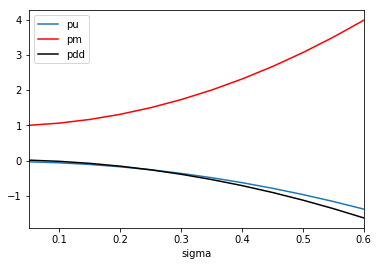

In [6]:
####QUESTION 1 PART 5
def prob(s, k, T, r, div, cp, nj, n=100):
    dt = T / n
    #edx = math.exp(dx)
    pu=[]
    pm=[]
    pdd=[]

    sigseq=np.arange(0.05,0.65,0.05)
    for sigm in np.arange(0.05,0.65,0.05):
        #dx= sigm*(math.sqrt(3*dt))
        v = r - div - 0.5 * (sigm ** 2)
        pu.append(-0.5 * dt * ((sigm / 0.2) ** 2 + v / 0.2))
        pm.append(1.0 + dt * (sigm / 0.2) ** 2 - r * dt)
        pdd.append(-0.5 * dt * ((sigm / 0.2) ** 2 - v / 0.2))

    d_dictionary={'sigma':sigseq,'pu':pu,'pm':pm,'pdd':pdd}
    table=pd.DataFrame(d_dictionary)
    return table

import matplotlib.pyplot as plt
import pandas as pd

ax = plt.gca()
proba=prob(s=100, k=100, T=1, r=0.06, div=0.03, cp=1, nj=3, n=3)
proba.plot(kind="line",x="sigma",y="pu",ax=ax)
proba.plot(kind="line",x="sigma",y="pm",color='red',ax=ax)
proba.plot(kind="line",x="sigma",y="pdd",color='black',ax=ax)
plt.show()

##NOTES: pu and pm are moving in inverse direction and pu and pd moves together as can be infered from the formula


In [7]:
#####QUESTION 1 PART 6

def greeks(s, k, T, sig, r, div, cp, nj, n=100):

    # initial calculations
    dt = T / n
    v = r - div - 0.5 * (sig ** 2)
    dx= sig*(math.sqrt(3*dt)) 
    edx = math.exp(dx)
    dsigma=0.0001*sig


    pu = 0.5 * dt * ((sig / dx) ** 2 + v / dx)
    pm = 1.0 - dt * (sig / dx) ** 2 - r * dt
    pd = 0.5 * dt * ((sig / dx) ** 2 - v / dx)
   

    disc = math.exp(-r * dt)
    St = np.zeros(2 * nj + 1)
    C = np.zeros(shape=(n + 1, 2 * nj + 1))
    # initialise the asset prices at maturity N

    St[0] = s * math.exp(-n * dx)

    for j in range(1, 2 * nj + 1, 1):
        St[j] = St[j - 1] * edx
   

    # initialise option values at maturity

    for i in range(-nj, nj + 1, 1):
        if cp==1:
            C[n, i] = max(0.0, St[i] - k)
        else:
            C[n, i] = max(0.0, k - St[i])


    # step back through tree

    for i in range(n - 1, -1, -1):
        for j in range(1, 2 * nj, 1):
            C[i, j] = pu * C[i + 1, j + 1] + pm * C[i + 1, j] + pd * C[i + 1, j - 1]
        C[i, 0] = C[i, 1]
        C[i, 2 * nj] = C[i, 2 * nj - 1] + (St[2 * nj] - St[2 * nj - 1])
    
    delta= ((C[0, nj+1 ])-C[0, (nj)-1])/(St[nj+1]-St[nj-1])
    gamma=((((C[0, nj+1 ])-C[0, (nj)])/(St[nj+1]-St[nj]))-(((C[0, nj ])-C[0, (nj)-1])/(St[nj]-St[nj-1])))/(((St[nj+1]-St[nj-1]))/2)
    theta=((C[1,2*nj]-C[0,2*nj])/dt)*0.01
    vega=0.01*(European_EFD(s=100, k=100, T=1, sig=(sig+dsigma), r=0.06, div=0.03, cp=1, nj=3, n=3)-European_EFD(s=100, k=100, T=1, sig=(sig-dsigma), r=0.06, div=0.03, cp=1, nj=3, n=3))/(2*dsigma)
    return delta,gamma,theta,vega

greek=greeks(s=100, k=100, T=1, sig=0.25, r=0.06, div=0.03, cp=1, nj=3, n=3)
print(f"delta is{greek[0]},gamma is {greek[1]},theta is {greek[2]},vega is {greek[3]}")



delta is0.5953602179502567,gamma is 0.014989287138426483,theta is -0.016681123509856805,vega is 0.3444322457184512


In [8]:
##########question 2 part 1


amzn = yf.Ticker("AMZN")
opt_maturity_dates_amzn=amzn.options
d_amzn={}
for i,x in enumerate(opt_maturity_dates_amzn):
     d_amzn["Maturity{0}".format(i)]=amzn.option_chain(x)

In [9]:
def blackscholes(S, K, T, r, sigma, option='call'):

    d1 = (np.log(float(S) / K) + (r + 0.5 * sigma ** 2) * T) / (sigma *
         np.sqrt(T))
    d2 = (np.log(float(S) / K) + (r - 0.5 * sigma ** 2) * T) / (sigma *
         np.sqrt(T))
    if option == 'call':
        result = (S * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0))
    if option == 'put':
        result = (K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0) - S *
              si.norm.cdf(-d1, 0.0, 1.0))
    return result
#print(blackscholes(50, 100, 1, 0.0225, 0.25,'call'))

def vega (S,K,T,r,sigma):
    d1 = float(np.log(S/K))/(sigma*float(np.sqrt(T))) + float((r+ (sigma*sigma)/2)*T/(sigma*float(np.sqrt(T))))
    vega = S*float(si.norm.pdf(np.float(d1)))*float(np.sqrt(T))
    return(vega)
    

def newtons_method(S, K, T, r, market, x0,option='call'):
    e = float(10e-15)
    delta = blackscholes (S, K, T, r, x0, option) - market
    
    while  delta > e :
        x0 = x0 - (blackscholes(S, K, T, r, x0, option) - market)/vega (S,K,T,r,x0)
        delta = abs(blackscholes(S, K, T, r, x0, option) - market)
        return abs((float(x0)))
    

def meanIV(S,Df1,T,r,option):
    Df1["moneyness"]=S/Df1["strike"]
    #print("Implied volatility is",newtons_method(1785, 1400,0.6 , 0.0225, (437.1+440.1)/2,1))
    #moneyness is used othervise vega will be zero and imp vol will be infinity
    mask=Df1["moneyness"].between(0.95,1.05)
    
    Df1_moneyness=Df1[mask]
    
    imp_df1_all=[]
    for index, row in Df1.iterrows():
        imp_df1_all.append(newtons_method(S,row["strike"],T,r,(row["bid"]+row["ask"])/2,1,option))
    
    imp_df1_moneyness=[]
    for index, row in Df1_moneyness.iterrows():
        imp_df1_moneyness.append(newtons_method(S,row["strike"],T,r,(row["bid"]+row["ask"])/2,1,option))
        
    Df1_moneyness["IV"] = pd.Series(imp_df1_moneyness, index=Df1_moneyness.index)
    Df1["IV"] = pd.Series(imp_df1_all, index=Df1.index)

    #inthemoney_mean_Df1_moneyness=Df1_moneyness.loc[(Df1_moneyness["inTheMoney"]==True)].mean()
    #outthemoney_mean_Df1_moneyness=Df1_moneyness.loc[(Df1_moneyness["inTheMoney"]==False)].mean()
    atthemoney_mean=(Df1_moneyness.mean())["IV"]
    #print("at the money mean implied volatility is",atthemoney_mean)
    return Df1_moneyness,Df1,atthemoney_mean#(for all imp vol table)


amzn_1128_calls=d_amzn["Maturity4"][0]
amzn_1128_puts=d_amzn["Maturity4"][1]

amzn_0116_calls=d_amzn["Maturity7"][0]
amzn_0116_puts=d_amzn["Maturity7"][1]

amzn_1219_calls=d_amzn["Maturity6"][0]
amzn_1219_puts=d_amzn["Maturity6"][1]
amzn.options

tau=pd.Timestamp('2019-10-27')#present date
tlist=[]
for x in amzn.options:
    tlist.append(pd.Timestamp(x))
tlist = [(x - tau) for x in tlist]
tlist=[x.days for x in tlist]
tlist=[x/365 for x in tlist]

ATM_imp_amzn_calls_1219,imp_amzn_calls_1219,ATM_mean_value_amzn_calls_1219 = meanIV(1761.23,amzn_1219_calls,tlist[6],0.0185,'call')
ATM_imp_amzn_puts_1219,imp_amzn_puts_1219,ATM_mean_value_amzn_puts_1219=meanIV(1761.23,amzn_1219_puts,tlist[6],0.0185,'put')
ATM_imp_amzn_calls_0116,imp_amzn_calls_0116,ATM_mean_value_amzn_calls_0116 = meanIV(1761.23,amzn_0116_calls,tlist[7],0.0185,'call')
ATM_imp_amzn_puts_0116,imp_amzn_puts_0116,ATM_mean_value_amzn_puts_0116=meanIV(1761.23,amzn_0116_puts,tlist[7],0.0185,'put')
ATM_imp_amzn_calls_1128,imp_amzn_calls_1128,ATM_mean_value_amzn_calls_1128 = meanIV(1761.23,amzn_1128_calls,tlist[4],0.0185,'call')
ATM_imp_amzn_puts_1128,imp_amzn_puts_1128,ATM_mean_value_amzn_puts_1128=meanIV(1761.23,amzn_1128_puts,tlist[4],0.0185,'put')

ATM_imp_amzn_calls_1219=ATM_imp_amzn_calls_1219[['strike','bid','ask','IV']]

ATM_imp_amzn_puts_1219=ATM_imp_amzn_puts_1219[['strike','bid','ask','IV']]

ATM_imp_amzn_calls_0116=ATM_imp_amzn_calls_0116[['strike','bid','ask','IV']]

ATM_imp_amzn_puts_0116=ATM_imp_amzn_puts_0116[['strike','bid','ask','IV']]

ATM_imp_amzn_calls_1128=ATM_imp_amzn_calls_1128[['strike','bid','ask','IV']]

ATM_imp_amzn_puts_1128=ATM_imp_amzn_puts_1128[['strike','bid','ask','IV']]

D:\pythonanaconda\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [10]:
###2.2

ATM_imp_amzn_calls_0116_pred_price=[]

for index, row in ATM_imp_amzn_calls_0116.iterrows():
    ATM_imp_amzn_calls_0116_pred_price.append(European_EFD(1761.23,row["strike"],tlist[7],row["IV"],0.0185,div=0,cp=1,nj=300, n=300))
ATM_imp_amzn_calls_0116["European_EFD_price"]=ATM_imp_amzn_calls_0116_pred_price
ATM_imp_amzn_calls_0116=ATM_imp_amzn_calls_0116[['strike','bid','ask','IV','European_EFD_price']]
#ATM_imp_amzn_calls_0116.head()



ATM_imp_amzn_calls_0116_pred_price=[]

for index, row in ATM_imp_amzn_calls_0116.iterrows():
    ATM_imp_amzn_calls_0116_pred_price.append(European_IFD(1761.23,row["strike"],tlist[7],row["IV"],0.0185,div=0,cp=1,nj=300, n=300))
ATM_imp_amzn_calls_0116["European_IFD_price"]=ATM_imp_amzn_calls_0116_pred_price
#ATM_imp_amzn_calls_0116=ATM_imp_amzn_calls_0116[['strike','bid','ask','IV','European_IFD_price']]
#ATM_imp_amzn_calls_0116.head()



ATM_imp_amzn_calls_0116_pred_price=[]

for index, row in ATM_imp_amzn_calls_0116.iterrows():
    ATM_imp_amzn_calls_0116_pred_price.append(European_CNFD(1761.23,row["strike"],tlist[7],row["IV"],0.0185,div=0,cp=1,nj=300, n=300))
ATM_imp_amzn_calls_0116["European_CNFD_price"]=ATM_imp_amzn_calls_0116_pred_price
#ATM_imp_amzn_calls_0116=ATM_imp_amzn_calls_0116[['strike','bid','ask','IV','European_CNFD_price']]
ATM_imp_amzn_calls_0116.head()


,strike,bid,ask,IV,European_EFD_price,European_IFD_price,European_CNFD_price
108,1680.0,134.35,136.30,0.261530,135.597128,135.539811,135.568471
109,1700.0,120.05,121.95,0.250277,119.730285,119.669929,119.700116
110,1720.0,106.55,108.10,0.240148,104.814569,104.752274,104.783436
111,1740.0,93.70,95.35,0.231818,91.067178,91.003989,91.035602
112,1760.0,81.75,83.40,0.225173,78.575719,78.513065,78.544411


# 2.2

In [11]:
def European_EFD_error(s, k, T, sig, r, div, cp):

    price =[]
    error =1
    for i in range(3,1000):
        error = abs(European_EFD(s, k, T, sig, r, div, cp, i, i)-European_EFD(s, k, T, sig, r, div, cp, i+1, i+1))
        if error <= 0.001:
           break
    dx = sig*math.sqrt(3*float(T/i))
    return dx

def European_IFD_error(s, k, T, sig, r, div, cp):

    price =[]
    error =1
    for i in range(3,1000):
        error = abs(European_IFD(s, k, T, sig, r, div, cp, i, i)-European_IFD(s, k, T, sig, r, div, cp, i+1, i+1))
        if error <= 0.001:
           break   
    dx = sig*math.sqrt(3*float(T/i))
    return dx

def European_CNFD_error(s, k, T, sig, r, div, cp):

    price =[]
    error =1
    for i in range(3,1000):
        error = abs(European_CNFD(s, k, T, sig, r, div, cp, i, i)-European_CNFD(s, k, T, sig, r, div, cp, i+1, i+1))
        if error <= 0.001:
           break
    dx = sig*math.sqrt(3*float(T/i))
    return dx

space=[]
for index, row in ATM_imp_amzn_calls_0116.iterrows():
   space.append(European_EFD_error(1761.23,row["strike"],tlist[7],row["IV"],0.0185,div=0,cp=1))
ATM_imp_amzn_calls_0116["European_EFD_dx"]=space
ATM_imp_amzn_calls_0116.head()

space=[]
for index, row in ATM_imp_amzn_calls_0116.iterrows():
   space.append(European_IFD_error(1761.23,row["strike"],tlist[7],row["IV"],0.0185,div=0,cp=1))
ATM_imp_amzn_calls_0116["European_IFD_dx"]=space

space=[]
for index, row in ATM_imp_amzn_calls_0116.iterrows():
   space.append(European_CNFD_error(1761.23,row["strike"],tlist[7],row["IV"],0.0185,div=0,cp=1))
ATM_imp_amzn_calls_0116["European_CNFD_dx"]=space

ATM_imp_amzn_calls_0116.head()

,strike,bid,ask,IV,European_EFD_price,European_IFD_price,European_CNFD_price,European_EFD_dx,European_IFD_dx,European_CNFD_dx
108,1680.0,134.35,136.30,0.261530,135.597128,135.539811,135.568471,0.032542,0.030800,0.031811
109,1700.0,120.05,121.95,0.250277,119.730285,119.669929,119.700116,0.024764,0.023272,0.024066
110,1720.0,106.55,108.10,0.240148,104.814569,104.752274,104.783436,0.017456,0.037030,0.016927
111,1740.0,93.70,95.35,0.231818,91.067178,91.003989,91.035602,0.037095,0.021555,0.026486
112,1760.0,81.75,83.40,0.225173,78.575719,78.513065,78.544411,0.016303,0.013471,0.014570


In [12]:
def greeks(s, k, T, sig, r, div, cp, nj, n=100):

    # initial calculations
    dt = T / n
    v = r - div - 0.5 * (sig ** 2)
    dx= sig*(math.sqrt(3*dt)) 
    edx = math.exp(dx)
    dsigma=0.0001*sig


    pu = 0.5 * dt * ((sig / dx) ** 2 + v / dx)
    pm = 1.0 - dt * (sig / dx) ** 2 - r * dt
    pd = 0.5 * dt * ((sig / dx) ** 2 - v / dx)
   

    disc = math.exp(-r * dt)
    St = np.zeros(2 * nj + 1)
    C = np.zeros(shape=(n + 1, 2 * nj + 1))
    # initialise the asset prices at maturity N

    St[0] = s * math.exp(-n * dx)

    for j in range(1, 2 * nj + 1, 1):
        St[j] = St[j - 1] * edx
   

    # initialise option values at maturity

    for i in range(-nj, nj + 1, 1):
        if cp==1:
            C[n, i] = max(0.0, St[i] - k)
        else:
            C[n, i] = max(0.0, k - St[i])


    # step back through tree

    for i in range(n - 1, -1, -1):
        for j in range(1, 2 * nj, 1):
            C[i, j] = pu * C[i + 1, j + 1] + pm * C[i + 1, j] + pd * C[i + 1, j - 1]
        C[i, 0] = C[i, 1]
        C[i, 2 * nj] = C[i, 2 * nj - 1] + (St[2 * nj] - St[2 * nj - 1])
    
    delta= ((C[0, nj+1 ])-C[0, (nj)-1])/(St[nj+1]-St[nj-1])
    gamma=((((C[0, nj+1 ])-C[0, (nj)])/(St[nj+1]-St[nj]))-(((C[0, nj ])-C[0, (nj)-1])/(St[nj]-St[nj-1])))/(((St[nj+1]-St[nj-1]))/2)
    theta=((C[1,2*nj]-C[0,2*nj])/dt)*0.01
    vega=0.01*(European_EFD(s, k, T, sig=(sig+dsigma), r=0.06, div=0.03, cp=1, nj=3, n=3)-European_EFD(s=100, k=100, T=1, sig=(sig-dsigma), r=0.06, div=0.03, cp=1, nj=3, n=3))/(2*dsigma)
    return delta,gamma,theta,vega


delta1=[]
for index, row in ATM_imp_amzn_calls_0116.iterrows():
   delta1.append(greeks(1761.23,row["strike"],tlist[7],row["IV"],0.0185,div=0,cp=1,nj=100)[0])
ATM_imp_amzn_calls_0116["delta"]=delta1

gamma1=[]
for index, row in ATM_imp_amzn_calls_0116.iterrows():
   gamma1.append(greeks(1761.23,row["strike"],tlist[7],row["IV"],0.0185,div=0,cp=1,nj=100)[1])
ATM_imp_amzn_calls_0116["gamma"]=gamma1

theta1=[]
for index, row in ATM_imp_amzn_calls_0116.iterrows():
   theta1.append(greeks(1761.23,row["strike"],tlist[7],row["IV"],0.0185,div=0,cp=1,nj=100)[2])
ATM_imp_amzn_calls_0116["theta"]=theta1

vega1=[]
for index, row in ATM_imp_amzn_calls_0116.iterrows():
   vega1.append(greeks(1761.23,row["strike"],tlist[7],row["IV"],0.0185,div=0,cp=1,nj=100)[3])
ATM_imp_amzn_calls_0116["vega"]=vega1

ATM_imp_amzn_calls_0116.head()

,strike,bid,ask,IV,European_EFD_price,European_IFD_price,European_CNFD_price,European_EFD_dx,European_IFD_dx,European_CNFD_dx,delta,gamma,theta,vega
108,1680.0,134.35,136.30,0.261530,135.597128,135.539811,135.568471,0.032542,0.030800,0.031811,0.683305,0.001637,-0.309553,24704.878328
109,1700.0,120.05,121.95,0.250277,119.730285,119.669929,119.700116,0.024764,0.023272,0.024066,0.652861,0.001773,-0.313248,22487.538019
110,1720.0,106.55,108.10,0.240148,104.814569,104.752274,104.783436,0.017456,0.037030,0.016927,0.618596,0.001908,-0.316939,20012.682174
111,1740.0,93.70,95.35,0.231818,91.067178,91.003989,91.035602,0.037095,0.021555,0.026486,0.580546,0.002025,-0.320626,17271.266877
112,1760.0,81.75,83.40,0.225173,78.575719,78.513065,78.544411,0.016303,0.013471,0.014570,0.539373,0.002124,-0.324312,14303.354334


In [14]:
ATM_imp_amzn_calls_0116[["strike","delta","gamma","theta","vega"]]

,strike,delta,gamma,theta,vega
108,1680.0,0.683305,0.001637,-0.309553,24704.878328
109,1700.0,0.652861,0.001773,-0.313248,22487.538019
110,1720.0,0.618596,0.001908,-0.316939,20012.682174
111,1740.0,0.580546,0.002025,-0.320626,17271.266877
112,1760.0,0.539373,0.002124,-0.324312,14303.354334
113,1780.0,0.496179,0.002176,-0.327997,12868.133073
114,1800.0,0.452399,0.002190,-0.331682,11492.207743
115,1810.0,0.430905,0.002177,-0.333525,10798.509624
116,1815.0,0.420292,0.002167,-0.334446,10454.675846
117,1820.0,0.409593,0.002158,-0.335367,10108.550923


question 3

In [17]:
import numpy as np
import pandas as pd
from scipy.integrate import quad
import scipy
 
from math import sqrt, exp, log, pi
import cmath
 
S = 100
K = 100
v = 0.0625
sigma = 0.5
rho = 0.6
k = 2
theta = 0.09
r = 0.06
tau = 1
x = log(S)
u1 = 0.5
u2 = -0.5
b1 = k  - rho*sigma
b2 = k 
a = k*theta
y = 0.0
def get_d(rho,sigma,phi,b1,b2,u1,u2):
    
    d1 = cmath.sqrt( (1j*rho*sigma*phi - b1)**2 - sigma**2*(1j*2*u1*phi - phi**2) )
    d2 = cmath.sqrt( (1j*rho*sigma*phi - b2)**2 - sigma**2*(1j*2*u2*phi - phi**2) )
 
    return([d1,d2])
 
def get_g(rho,sigma,phi,b1,b2,u1,u2,d1,d2):
 
    g1 = (b1 - 1j*rho*sigma*phi + d1)/(b1 - 1j*rho*sigma*phi - d1)
    g2 = (b2 - 1j*rho*sigma*phi + d2)/(b2 - 1j*rho*sigma*phi - d2)
    
    return([g1,g2])
    
def get_D(rho,sigma,phi,b1,b2,u1,u2,d1,d2,g1,g2):
 
    D1 = (b1 - 1j*rho*sigma*phi + d1)/sigma**2*((1 - cmath.exp(d1*tau))/(1 - g1*cmath.exp(d1*tau)))
    D2 = (b2 - 1j*rho*sigma*phi + d2)/sigma**2*((1 - cmath.exp(d2*tau))/(1 - g2*cmath.exp(d2*tau)))
    
    return([D1,D2])
    
def get_C(r, phi, tau, a, sigma,b1,b2,rho,d1,d2,g1,g2):
    C1 = r*phi*1j*tau + a/phi**2 * ( (b1 - 1j*rho*sigma*phi + d1)*tau - 2 * cmath.log((1 - g1*cmath.exp(d1*tau))/(1-g1)))
    C2 = r*phi*1j*tau + a/phi**2 * ( (b2 - 1j*rho*sigma*phi + d2)*tau - 2 * cmath.log((1 - g2*cmath.exp(d2*tau))/(1-g2)))
    return([C1,C2])
    
def get_f(r, phi, tau, a, sigma,b1,b2,rho,d1,d2,g1,g2,C1,C2,D1,D2,v,x):
    f1 = cmath.exp(C1 + D1*v + 1j*phi*x)
    f2 = cmath.exp(C2 + D2*v + 1j*phi*x)
    return([f1,f2])

def heston_phi(k, tau, sigma, v, lambd, theta, rho ):
	
	b = lambd + 1j*rho*theta*k
	d = sqrt( b**2 + (theta**2)*k*(k-1j) )
	g = (b - d)/(b + d)
	T_m = (b - d)/(theta**2)
	T = T_m * ( 1 - exp(-d*tau) )/( 1 - g*exp(-d*tau) )
	W = lambd * vbar * ( tau*T_m - 2*log( ( 1 - g*exp(-d*tau) )/( 1 - g ) )/(eta**2) )
	
	return exp(W + v*T)


def heston_phi_transform(tau, x, parms,sigma, v, lambd, theta, rho ):
	integrand = lambda k: 2 * real( exp(-1j*k*x) * heston_phi(k + 0.5*1j, tau, *parms) )/(k**2 + 1.0/4.0)
	return quad(integrand, 0, 50)[0]

def integrand1(phi):
    [d1,d2] = get_d(rho,sigma,phi,b1,b2,u1,u2)
    [g1,g2] = get_g(rho,sigma,phi,b1,b2,u1,u2,d1,d2)
    [D1,D2] = get_D(rho,sigma,phi,b1,b2,u1,u2,d1,d2,g1,g2)
    [C1,C2] = get_C(r, phi, tau, a, sigma,b1,b2,rho,d1,d2,g1,g2)
    [f1,f2] = get_f(r, phi, tau, a, sigma,b1,b2,rho,d1,d2,g1,g2,C1,C2,D1,D2,v,x)
    val = cmath.exp(-1j*phi*log(K))*f1/(1j*phi)
    return(val.real)
 
def integrand2(phi):
    [d1,d2] = get_d(rho,sigma,phi,b1,b2,u1,u2)
    [g1,g2] = get_g(rho,sigma,phi,b1,b2,u1,u2,d1,d2)
    [D1,D2] = get_D(rho,sigma,phi,b1,b2,u1,u2,d1,d2,g1,g2)
    [C1,C2] = get_C(r, phi, tau, a, sigma,b1,b2,rho,d1,d2,g1,g2)
    [f1,f2] = get_f(r, phi, tau, a, sigma,b1,b2,rho,d1,d2,g1,g2,C1,C2,D1,D2,v,x)
    val = cmath.exp(-1j*phi*log(K))*f2/(1j*phi)
    return(val.real)
 
#get price of call option using Heston model
def get_price():
    P1 = 1/2 + 1/pi * quad(integrand1, 0, 100)[0]
    P2 = 1/2 + 1/pi * quad(integrand2, 0, 100)[0]
    C = S*P1 - exp(-(r-y)*tau)*K*P2
    P=C+(K/(1+r)**tau)-100
    return(P)
 
get_price() 



2.676112853887105